In [63]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [ ]:
benchmark = '16qbt'

In [65]:
csv_files = glob.glob(f"data/*{benchmark}*csv")
len(csv_files)

1

In [66]:
df_list = [pd.read_csv(file) for file in csv_files]
df = pd.concat(df_list, ignore_index=True)
df = df.sort_values('file_path')

In [67]:
df.index = list(range(len(df)))

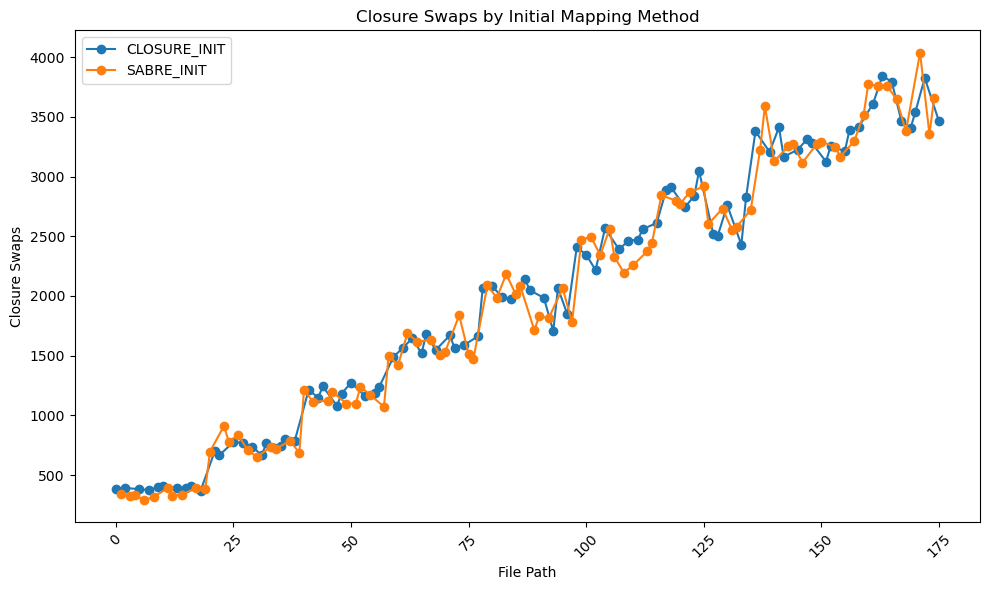

In [68]:
plt.figure(figsize=(10, 6))
for method in ['CLOSURE_INIT', 'SABRE_INIT']:
    method_df = df[df['initial_mapping_method'] == method]
    plt.plot( method_df['closure_swaps'], marker='o', label=method)
plt.xlabel('File Path')
plt.ylabel('Closure Swaps')
plt.title('Closure Swaps by Initial Mapping Method')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

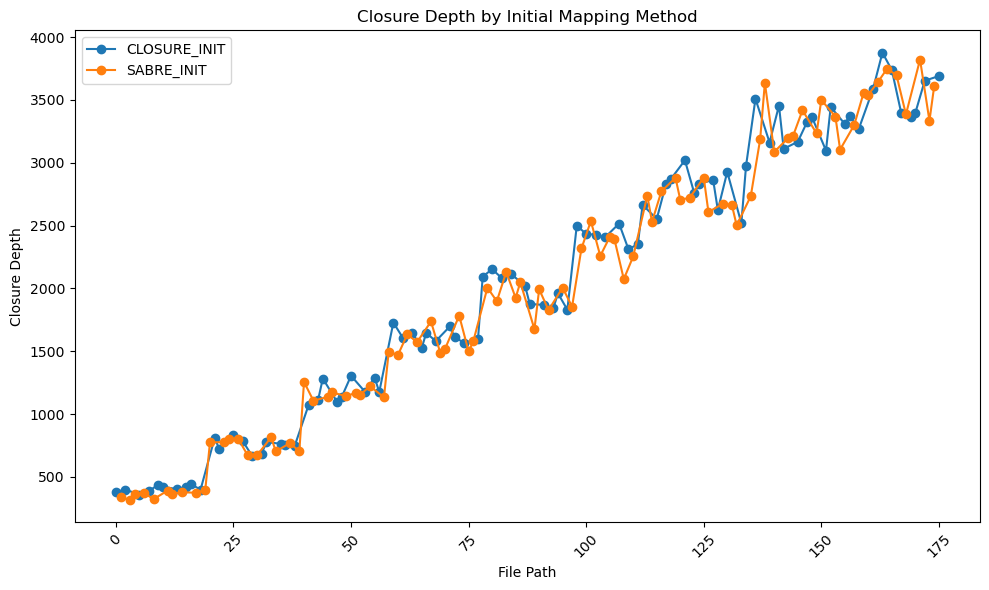

In [69]:
plt.figure(figsize=(10, 6))
for method in ['CLOSURE_INIT', 'SABRE_INIT']:
    method_df = df[df['initial_mapping_method'] == method]
    plt.plot( method_df['closure_depth'], marker='o', label=method)
plt.xlabel('File Path')
plt.ylabel('Closure Depth')
plt.title('Closure Depth by Initial Mapping Method')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [70]:
# --- Compute Improvement ---
# Pivot the DataFrame so each file_path has columns for each initial mapping method.
pivot_swaps = df.pivot(index='file_path', columns='initial_mapping_method', values='closure_swaps')
pivot_depth = df.pivot(index='file_path', columns='initial_mapping_method', values='closure_depth')

# Only include file paths that have data for both methods
pivot_swaps = pivot_swaps.dropna(subset=['CLOSURE_INIT', 'SABRE_INIT'])
pivot_depth = pivot_depth.dropna(subset=['CLOSURE_INIT', 'SABRE_INIT'])

# Calculate absolute improvement (using SABRE_INIT as reference)
# Positive improvement indicates CLOSURE_INIT produced lower values.
pivot_swaps['improvement'] =  pivot_swaps['CLOSURE_INIT'] - pivot_swaps['SABRE_INIT'] 
pivot_depth['improvement'] = pivot_depth['CLOSURE_INIT'] - pivot_depth['SABRE_INIT'] 

# Calculate percentage improvement, handling SABRE_INIT as the base.
pivot_swaps['percent_improvement'] = (
    pivot_swaps['improvement'] / pivot_swaps['CLOSURE_INIT']) * 100
pivot_depth['percent_improvement'] = (
    pivot_depth['improvement'] / pivot_depth['CLOSURE_INIT']) * 100


# Calculate and print overall average improvements
avg_swaps_improvement = pivot_swaps['improvement'].mean()
avg_depth_improvement = pivot_depth['improvement'].mean()
avg_swaps_percent = pivot_swaps['percent_improvement'].mean()
avg_depth_percent = pivot_depth['percent_improvement'].mean()

print("\nAverage Improvement in Closure Swaps: {:.2f} ({}% improvement)".format(avg_swaps_improvement, round(avg_swaps_percent, 2)))
print("Average Improvement in Closure Depth: {:.2f} ({}% improvement)".format(avg_depth_improvement, round(avg_depth_percent, 2)))


Average Improvement in Closure Swaps: 17.67 (1.89% improvement)
Average Improvement in Closure Depth: 33.97 (2.43% improvement)


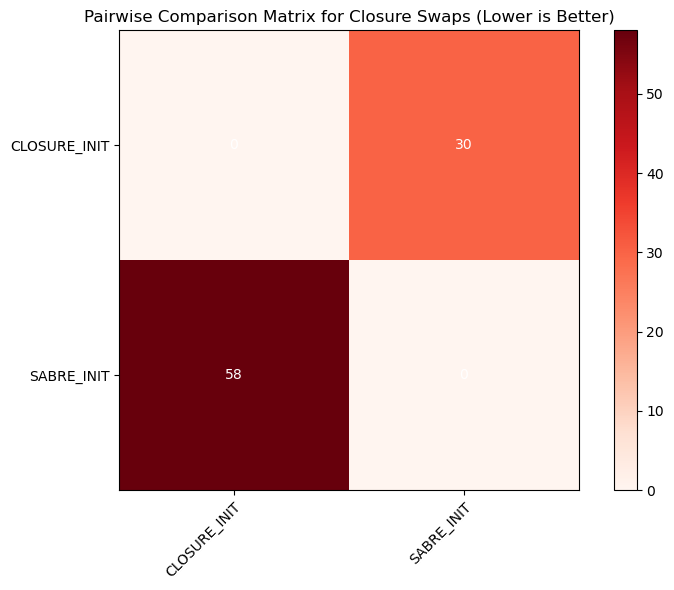

In [71]:
dag_modes = ['CLOSURE_INIT', 'SABRE_INIT']

# For Closure Swaps
comparison_matrix_swaps = pd.DataFrame(0, index=dag_modes, columns=dag_modes)
for idx, row in pivot_swaps.iterrows():
    for mode_i in dag_modes:
        for mode_j in dag_modes:
            if mode_i != mode_j:
                if row[mode_i] < row[mode_j]:
                    comparison_matrix_swaps.loc[mode_i, mode_j] += 1

# Plot confusion matrix for Closure Swaps
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(comparison_matrix_swaps, cmap='Reds')
ax.set_xticks(np.arange(len(comparison_matrix_swaps.columns)))
ax.set_yticks(np.arange(len(comparison_matrix_swaps.index)))
ax.set_xticklabels(comparison_matrix_swaps.columns)
ax.set_yticklabels(comparison_matrix_swaps.index)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(comparison_matrix_swaps.index)):
    for j in range(len(comparison_matrix_swaps.columns)):
        ax.text(j, i, comparison_matrix_swaps.iloc[i, j],
                ha="center", va="center", color="white")
ax.set_title("Pairwise Comparison Matrix for Closure Swaps (Lower is Better)")
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()